[View in Colaboratory](https://colab.research.google.com/github/paulanavarretec/RecSys-Tarea1/blob/master/Recsys_Tarea1.ipynb)

# Recommender Algorithms for a Beer Selling platform


---



In this asisgnment I develop several Recommender algorithms and test their performance. I use pyreclab Python library, developed by IALab & SocVis from the Pontifical Catholic University of Chile.

The algorithms developed ahead are:

> UserKnn

> ItemKnn

> SlopeOne

> SVD


> ALS o ALScg: (este modelo lo puede usar para la tarea de ranking. Si tiene problemas con pyreclab, puede usar la biblioteca implicit1).

# Data Load and Exploration

Download to local computer the relevant files through the following links:

(update links)

https://drive.google.com/file/d/1Anro2DyEgN0sUHXFyxVe2qoSya6hzQSp/view?usp=sharing

https://drive.google.com/file/d/1Awy3QKCdkSpNeRXATqRBUMi56M47Ia0n/view?usp=sharing

https://drive.google.com/file/d/1B7QhEodQ13QlOHOTp9zaa52exlfgAOl3/view?usp=sharing


In [3]:
#Run this cell. You must upload the files to be used to analyse: training_data.csv, test_rating_data.csv y ranking_users.txt
from google.colab import files
uploaded = files.upload()

Saving training_data.csv to training_data.csv
Saving ranking_users.txt to ranking_users (1).txt
Saving test_rating_data.csv to test_rating_data (1).csv


*training_data.csv* and *test_data.csv* files have tuples of the form {'obsNo', 'userID',  'itemID',  'styleID', 'rating', 'brewerID', 'timestamp'} wich is the information of user preferences among the diferent beer features.

Let's load the files into pandas data structure to be handled:

In [0]:
import pandas as pd #Import library

#Read both train and test files into separate data structures
train_file = pd.read_csv('training_data.csv',
                         sep=',',
                         names = ['obsNo','userID', 'itemID', 'styleID', 'rating','brewerID','timestamp'],
                         header=0)

test_file = pd.read_csv('test_rating_data.csv',                    
                         sep=',',
                         names = ['obsNo','itemID',  'styleID',  'userID',  'brewerID',   'timestamp'],
                         header=0)

### Looking at the numbers 

The head and tail of the training_data.csv can be visualized as follows, among with the other columns.

In [122]:
print(train_file.head())
print(train_file.tail(),'\n\n')

   obsNo  userID  itemID  styleID  rating  brewerID   timestamp
0      0    4924   11757     1199     4.5      1199  1247372118
1      1    4924    5441     1199     4.5      1199  1209176445
2      2    4924   19960     1199     5.0      1199  1223914717
3      3    2916   55900     1199     2.5      1199  1291336093
4      4    2916   57110    14879     4.0     14879  1279318326
       obsNo  userID  itemID  styleID  rating  brewerID   timestamp
44347  44374    3230   11757     1199     5.0      1199  1286494547
44348  44375    4630   11757     1199     2.5      1199  1254948632
44349  44376    6118   20470      394     4.0       394  1204330634
44350  44377    6118    1324      263     3.5       263  1212967655
44351  44378    7268    1504      568     5.0       568  1157647130 




As we can see, users and items are represented by an integer, style and brewer too, rating is represented with a decimal  numer and they all range in a wide spectrum. But we need a little bit more information to see if we have enough users and/or items to be able to predict something.

Let's get some stats out of the sample. The following code gets the total number of unique instances for each column, i.e. how many different users,  items, styles, rating, brewerID and timestamps there are:

In [123]:
print(train_file.nunique())


uniqueVals = train_file["styleID"].unique()
uniqueVals = train_file["brewerID"].unique()
print("Son iguales?",bool(set(train_file['styleID']).intersection(train_file["brewerID"])))

obsNo        44352
userID        8318
itemID        1836
styleID        210
rating          10
brewerID       210
timestamp    43905
dtype: int64
Son iguales? True


This is nice because we have a large sample, compounded by many (but a lot less) items ans users, we have more users than items (as spected). We have ten different decimal ratings (i guess 0 to 10 incremented by 0.1). And lukily we have a lot less styles and brewers.

### Summary statistics

Now, let's take a deeper look into de shape of the data, to do that, I use differen statistic functions provided by pandas library. Let's take a look:

In [127]:
# print('Summary\n\n',train_file.describe(),'\n')
train_file.describe()

,obsNo,userID,itemID,styleID,rating,brewerID,timestamp
count,44352.000000,44352.000000,44352.000000,44352.000000,44352.000000,44352.000000,4.435200e+04
mean,22191.016031,3205.841698,21296.386273,2972.899238,3.864910,2972.899238,1.229025e+09
std,12812.864346,2391.127797,18548.835555,5037.020714,0.712695,5037.020714,7.173668e+07
min,0.000000,1.000000,175.000000,1.000000,0.000000,1.000000,9.262944e+08
25%,11096.750000,1130.000000,5441.000000,395.000000,3.500000,395.000000,1.184526e+09
50%,22184.500000,2763.000000,17538.000000,1199.000000,4.000000,1199.000000,1.243485e+09
75%,33290.250000,5013.250000,34146.000000,1315.000000,4.500000,1315.000000,1.286939e+09
max,44378.000000,8320.000000,77207.000000,27797.000000,5.000000,27797.000000,1.326259e+09


In [128]:
# print('Median:\n',train_file.median(),'\n') # Sample median of rating values
train_file.median()

obsNo        2.218450e+04
userID       2.763000e+03
itemID       1.753800e+04
styleID      1.199000e+03
rating       4.000000e+00
brewerID     1.199000e+03
timestamp    1.243485e+09
dtype: float64

In [129]:
# print('Variance:\n',train_file.var(),'\n')    # Sample variance of rating values
train_file.var()

obsNo        1.641695e+08
userID       5.717492e+06
itemID       3.440593e+08
styleID      2.537158e+07
rating       5.079335e-01
brewerID     2.537158e+07
timestamp    5.146151e+15
dtype: float64

In [130]:
# print('Standard deviation:\n',train_file.std(),'\n')     # Sample standard deviation of rating values
train_file.std()

obsNo        1.281286e+04
userID       2.391128e+03
itemID       1.854884e+04
styleID      5.037021e+03
rating       7.126946e-01
brewerID     5.037021e+03
timestamp    7.173668e+07
dtype: float64

In [131]:
# print('Skew:\n',train_file.skew(),'\n')    # Skewness of rating values
train_file.skew()

obsNo       -0.000054
userID       0.497656
itemID       0.818074
styleID      2.390667
rating      -1.013625
brewerID     2.390667
timestamp   -0.833778
dtype: float64

In [132]:
# print('Kurtosis:\n',train_file.kurt(),'\n')    # Kurtosis of rating values
train_file.kurt()

obsNo       -1.200353
userID      -0.941630
itemID      -0.260603
styleID      4.779249
rating       1.631286
brewerID     4.779249
timestamp   -0.017481
dtype: float64

In [134]:
(train_file.corr())    # Correlation Matrix Of Values

,obsNo,userID,itemID,styleID,rating,brewerID,timestamp
obsNo,1.000000,-0.003365,0.006654,-0.000982,0.008494,-0.000982,0.001472
userID,-0.003365,1.000000,-0.314421,-0.166903,-0.023358,-0.166903,-0.638473
itemID,0.006654,-0.314421,1.000000,0.524710,-0.019572,0.524710,0.424763
styleID,-0.000982,-0.166903,0.524710,1.000000,-0.082091,1.000000,0.206634
rating,0.008494,-0.023358,-0.019572,-0.082091,1.000000,-0.082091,0.059495
brewerID,-0.000982,-0.166903,0.524710,1.000000,-0.082091,1.000000,0.206634
timestamp,0.001472,-0.638473,0.424763,0.206634,0.059495,0.206634,1.000000


In [68]:
(train_file.cov())    # Covariance Matrix Of Values

,obsNo,userID,itemID,styleID,rating,brewerID,timestamp
obsNo,1.641695e+08,-1.030805e+05,1.581421e+06,-6.334947e+04,7.756751e+01,-6.334947e+04,1.353343e+09
userID,-1.030805e+05,5.717492e+06,-1.394539e+07,-2.010202e+06,-3.980498e+01,-2.010202e+06,-1.095183e+11
itemID,1.581421e+06,-1.394539e+07,3.440593e+08,4.902411e+07,-2.587404e+02,4.902411e+07,5.652037e+11
styleID,-6.334947e+04,-2.010202e+06,4.902411e+07,2.537158e+07,-2.946954e+02,2.537158e+07,7.466486e+10
rating,7.756751e+01,-3.980498e+01,-2.587404e+02,-2.946954e+02,5.079335e-01,-2.946954e+02,3.041758e+06
brewerID,-6.334947e+04,-2.010202e+06,4.902411e+07,2.537158e+07,-2.946954e+02,2.537158e+07,7.466486e+10
timestamp,1.353343e+09,-1.095183e+11,5.652037e+11,7.466486e+10,3.041758e+06,7.466486e+10,5.146151e+15


## Dataset Density

Now, let's see al these tendencies we've resumed in the numbers just examined. First I plot the density function of the user rankings. The following plot depicts the frecuency for the y-axis of reviews per user and a probability density function.

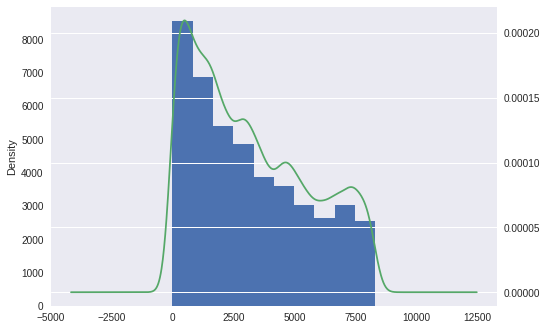

In [135]:
# train_file['userID'].plot.kde() 
# train_file['userID'].plot.hist() # or alternatively

ax = train_file.userID.plot(kind='hist')
train_file.userID.plot(kind='kde', ax=ax, secondary_y=True)

The shape is congruent with the tendency to have less users in the beginnig (the so*-called* early adopters) giving lots of ratings and helping the system to learn, and afterwads, a lot of new users giving a lot of less reviews. 

The same can be chequed out analogously for the items.

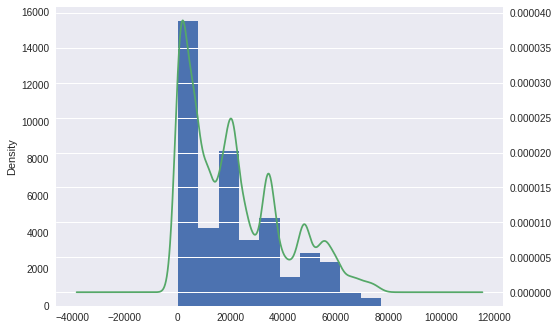

In [136]:
ax = train_file.itemID.plot(kind='hist')
train_file.itemID.plot(kind='kde', ax=ax, secondary_y=True)

It is interesting what this plot shows. We can see a sort of different waves, characterized by a peak of ratings for some items, but a comparable bigger tail of items rated comparatively less. This may suggest that new items were introduced in 4 to 5 waves along time, where we initial introductions brought several more reviews per item introduced than the later, making sens with the previously analisys of users.

## Dataset Distribution

### user/item Distribution

In [137]:
# print(train_file.groupby(['userID']).size().reset_index(name='itemsRated').head())
train_file.groupby(['userID']).size().reset_index(name='itemsRated').head()

,userID,itemsRated
0,1,22
1,2,18
2,3,16
3,4,39
4,5,12


In [138]:
(train_file.groupby(['userID']).size().reset_index(name='itemsRated').tail())

,userID,itemsRated
8313,8316,2
8314,8317,1
8315,8318,1
8316,8319,1
8317,8320,1


In [0]:
ser = pd.Series(train_file.groupby(['userID']).size().reset_index(name='itemsRated')['itemsRated'].tolist())
# (ser.describe())

## AGREGARLE QUE CUENTE CUÁNTOS USERS TIENEN 1, 2, 3, ..., 15<-(MEAN+STD_DEV) PARA QUE QUEDE MAS ILUSTRATIVO EL GRAFICO

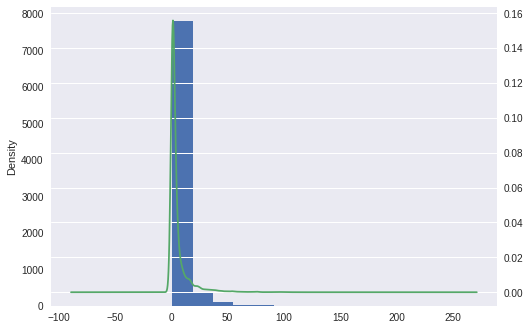

In [148]:
# ser.plot.kde()
ax = ser.plot(kind='hist')
ser.plot(kind='kde', ax=ax, secondary_y=True)
# ser

### item/user Distribution

In [141]:
(train_file.groupby(['itemID']).size().reset_index(name='usersRated').head())

,itemID,usersRated
0,175,71
1,176,118
2,178,83
3,429,1182
4,436,443


In [142]:
(train_file.groupby(['itemID']).size().reset_index(name='usersRated').tail())

,itemID,usersRated
1831,76997,2
1832,76998,1
1833,76999,1
1834,77198,1
1835,77207,1


In [143]:
ser = pd.Series(train_file.groupby(['itemID']).size().reset_index(name='usersRated')['usersRated'].tolist())
print(ser.describe())

count    1836.000000
mean       24.156863
std       113.849140
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max      2205.000000
dtype: float64


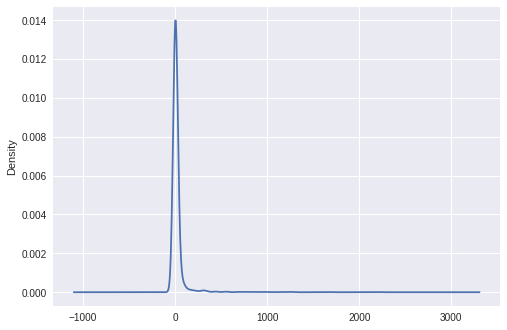

In [144]:
ser.plot.kde()

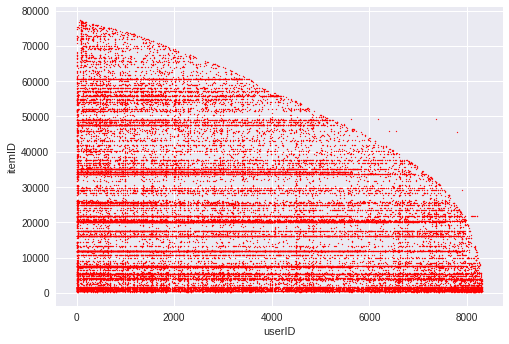

In [11]:
train_file.plot.scatter('userID','itemID', s=1, c='red')